Cahier IPython en cours d'élaboration....

    v1.0 2019/06/13 BA  MAJ par Benjamin AILLOUD (stage L2 informatique)    
    v1.1 2019/07/01 JLC MAJ des explications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

# A/ Machine Learning : Réseau de neurone convolutionnel

Le principe des réseaux convolutionnels est très différent de celui des réseaux denses vus précédemment.




<p style="text-align:center; font-style:italic; font-size=xx-small">
    <img src="./figures/cnn_doc.png" width="600" >
    (crédit image : JLC)
</p>

<img src="./figures/animationConvolution-1.gif">

L'objectif de ce TP est de comprendre le fonctionnement d'un `réseau convolutionnel` et sa construction via l'utilisation du module **keras** utilisé comme interface *high level* au module **tensorflow**. <br />

Comme vu précédemment pour le cas d'un `réseau dense`, la construction d'un `réseau convolutionnel` avec le module **keras** ne requiert pas plus d'une dizaine de lignes, encore faut-il être capable de les écrires en comprenant ce qu'on écrit

Le séquecement de ce TP reste essentiellement le même : 
- Import des images depuis la banque MNIST.
- Ici, les images ne sont plus vectorisées car les réseaux convolutionnels sont compatibles avec des entrées sous forme de matrices de pixels. Il subsiste une étape de traitement des données d'entrée pour rajouter les canaux de couleurs, suivie de l'étape de normalisation.
- `Hot encoding` des étiquettes pour les rendre comptaibles avec les sorties du réseau de neurones.
- Construction du modèle, entraînement.
- Analyse des résultats.

Petit rappel de cours: 
- Chaque étape de `convolution` comporte aussi une `activation` qui utilise généralement la fonction `relu`
- Un réseau de neuronne convolutionnel se termine par une couche dense

#  B/ Environnement Python de travail

<span style="color:brown;font-family:arial;font-size:large"> 
    Le travail qui suit doit se faire dans un <span style="font-weight:bold;">environnement Python 3.6 dédié</span>
    : voir le document <span style="font-style:italic">EnvironnementPython.pdf</span> si vous n'avez pas encore créé
    d'environnement Python dédié pour le travail avec les modules Keras et tensorflow.
</span>

### Environnement Python dédié
Vérification :
- de la version de Python : doit être 3.6.x
- de la version de keras : doit être 2.2.x
- de la version de tensorflow : doit être 1.14.x
- de la version de OpenCV : doit être 3.4.x

In [2]:
import sys, keras, cv2
import tensorflow as tf
print(f"Version de Python    : {sys.version.split()[0]}")
print(f"Version, de Keras    : {keras.__version__}")
print(f"Version de tensorflow: {tf.__version__}")
print(f"Version, de OpenCV   : {cv2.__version__}")

Using TensorFlow backend.


Version de Python    : 3.6.8
Version, de Keras    : 2.2.4
Version de tensorflow: 1.14.0
Version, de OpenCV   : 3.4.2


Incrustation des tracés matplotlib dans le cahier IPython et import de modules utiles :

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image

# C/ Travail à faire

## 1 -- Récupération du jeu de données MNIST 

https://fr.wikipedia.org/wiki/Base_de_données_MNIST : La base de données MNIST (*Mixed National Institute of Standards and Technology*), est une base de données de chiffres écrits à la main. C'est un jeu de données très utilisé en apprentissage automatique.<br /><br />
L'ensemble des images du jeu de données MNIST contient **60000 images d'apprentissage** et **10000 images de test**, soit en tout **70000 images** de 28 x 28 pixels.

In [4]:
import tensorflow  
import keras 

# Load data from https://www.openml.org/d/554
from keras.datasets import mnist
(image_train, etiq_train), (image_test, etiq_test) = mnist.load_data()

<span style="color:blue;font-family:arial">Afficher le type des objets `image_train`, `etiq_train`, `image_test` et `etiq_test` et leurs attributs `shape` et `dtype`:</span>

In [5]:
objs = (image_train, etiq_train, image_test, etiq_test)
print(f"type de image_train : {type(image_train)}, shape: {image_train.shape}, dtype: {image_train.dtype}")
print(f"type de etiq_train  : {type(etiq_train)}, shape: {etiq_train.shape}, dtype: {etiq_train.dtype}")
print(f"type de image_test  : {type(image_test)}, shape: {image_test.shape}, dtype: {image_test.dtype}")
print(f"type de etiq_test   : {type(etiq_test)}, shape: {etiq_test.shape}, dtype: {etiq_test.dtype}")

type de image_train : <class 'numpy.ndarray'>, shape: (60000, 28, 28), dtype: uint8
type de etiq_train  : <class 'numpy.ndarray'>, shape: (60000,), dtype: uint8
type de image_test  : <class 'numpy.ndarray'>, shape: (10000, 28, 28), dtype: uint8
type de etiq_test   : <class 'numpy.ndarray'>, shape: (10000,), dtype: uint8


## 2 -- *Hot coding* des étiquettes :

In [6]:
import numpy as np
from keras.utils import np_utils 

# Normalisation des valeurs de pixel
image_train = image_train/255
image_test  = image_test/255

y_train = np_utils.to_categorical(etiq_train)
y_test  = np_utils.to_categorical(etiq_test)

L'utilisation des réseaux de convolution nécessite des `inputs` prenant en compte le nombre de `canaux de couleur`, par exemple, une image RGB possède 3 canaux de couleurs alors qu'une image en noir et blanc n'en possède qu'un.
Pour l'instant nos inputs sont en format 2 dimensions où le canal de couleur n'est pas représenté.

In [7]:
print(image_train.shape)
print(image_test.shape)

(60000, 28, 28)
(10000, 28, 28)


<span style="color:blue;font-family:arial"> 
    On rajoute la dimension du 'canal gris' :
</span> 

In [8]:
x_train = image_train.reshape((60000,28,28,1))
x_test  = image_test.reshape((10000,28,28,1))

# 3 -- Construction du réseau de neurones :

<span style="color:blue;font-family:arial"> Cette fois-ci, c'est à toi de créer le **modèle** représenté dans l'image de début de tp, en utilisant le module `tensorflow`. 
    Pour créer les couches, tu dois utiliser les fonctions du module `tensorflow.keras.layers` : lit bien la doc et la description des arguments des fonctions: </span>
- **Conv2D**:<br /> 
`Première convolution`: 16 filtres, fenêtre 5$\times$5, activation : 'relu', input : (28, 28, 1)<br />
`Seconde convolution` : 32 filtres, fenêtre 5$\times$5, activation: 'relu'
- **MaxPooling2D** : Facteur de division des matrices en largeur et hauteur (2,2)
- **Dense** : Nombre de neuronne dans la couche = largeur output * hauteur output * nombre d'output de la couche précédente. <br> </br> Prendre en compte le pooling pour la taille des input !  
- **Flatten**



<span style="color:blue;font-family:arial"> Utiliser les infos précédentes pour donner les valeurs des paramètres du modèle : </span>

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

tf.logging.set_verbosity(tf.logging.ERROR)  # n'afficher que les ERREURS tf, pas les warnings....
nb_classes = len(y_train[0])
seed = 43
np.random.seed(seed)
num_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Première couche convolutionnelle correspondant à la couche d'entrée (input layer) : 32 filtres, fenêtre (5,5) :
#model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu'))
# Réduction des donnés :
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.25))
# Seconde couche convolutionnelle : 15 filtres, fenêtre(3,3)
#model.add(Conv2D(filters=15, kernel_size=(3,3), activation='relu'))
# Réduction des donnés :
#model.add(MaxPooling2D(pool_size=(2,2)))
# La fonction Dropout permet de désactiver certains neuronnes avec la probabilité définie ce qui permet d'éviter le 
# sur-apprentissage des neuronnes aussi appelé "overfitting"
#model.add(Dropout(0.2))
#model.add(Flatten())        # Vectorisation des matrices

# Couche dense pour finir :
#model.add(Dense(128, activation='relu', kernel_initializer='normal')) 
#model.add(Dense(50, activation='relu', kernel_initializer='normal')) 

#Couche dense de sortie (output layer)
#model.add(Dense(10, activation='softmax', kernel_initializer='normal'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 4 -- Entraînement du réseau :

In [39]:
# Pour vous faire gagner du temps car l'entrainement d'un réseau convolutionnel est bien plus long, on limitera
# le paramètre `epochs` à une valeur faible (5 à 10 par exemple).

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=8, batch_size=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 96s 2ms/sample - loss: 0.2149 - acc: 0.9341 - val_loss: 0.0522 - val_acc: 0.9829
Epoch 2/8
60000/60000 [==============================] - 69s 1ms/sample - loss: 0.0835 - acc: 0.9749 - val_loss: 0.0429 - val_acc: 0.9851
Epoch 3/8
60000/60000 [==============================] - 77s 1ms/sample - loss: 0.0618 - acc: 0.9819 - val_loss: 0.0310 - val_acc: 0.9890
Epoch 4/8
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0500 - acc: 0.9848 - val_loss: 0.0305 - val_acc: 0.9900
Epoch 5/8
60000/60000 [==============================] - 75s 1ms/sample - loss: 0.0418 - acc: 0.9869 - val_loss: 0.0286 - val_acc: 0.9904
Epoch 6/8
60000/60000 [==============================] - 72s 1ms/sample - loss: 0.0372 - acc: 0.9881 - val_loss: 0.0266 - val_acc: 0.9911
Epoch 7/8
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.0333 - acc: 0.9896 - val_loss: 0.0237 - 

### Tracé des courbes `accuracy` et `loss` :

In [34]:
def plot(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(15,5))
    ax1 = plt.subplot(1,2,1)
    ax1.plot(history.history['acc'], 'o-',label='Train')
    ax1.plot(history.history['val_acc'], 'o-', label='Test')
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch') 
    #ax1.set_ylim(0.96,1.)
    #ax1.set_yticks(np.arange(.96,1.0,0.005))
    ax1.grid()
    ax1.legend(loc='best')
    # Plot training & validation loss values
    ax2 = plt.subplot(1,2,2)
    ax2.plot(history.history['loss'], 'o-', label='Train')
    ax2.plot(history.history['val_loss'], 'o-',  label='Test')
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='best')
    #ax2.set_ylim(0.,0.07)
    #ax2.set_yticks(np.arange(0,0.07,0.01))
    ax2.grid()
    plt.show()

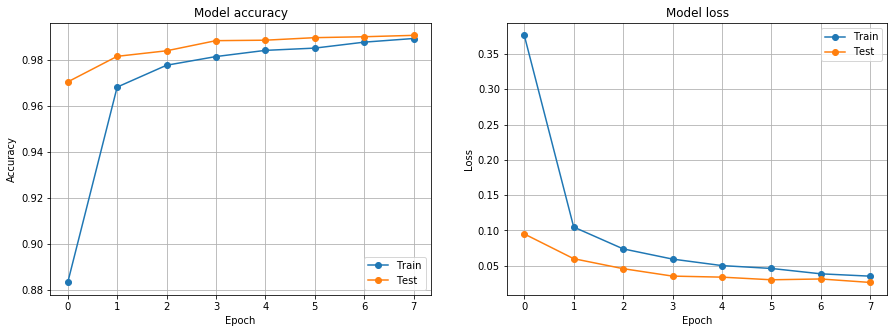

In [35]:
plot(history)

# 5/ Vérication de l'apprentissage avec le jeu de test

La méthode `predict`permet de demander au modèle sa prédic£tion pour une ou plusieurs entrées.<BR />
Exemple de prédition pour une image test numéro i dans le jeu d'images de test (0 <= i <= 10000) :

In [40]:
results = model.predict_on_batch(x_test)
bonne_rep = 0
for i, res in enumerate(results):
    bonne_rep += (np.argmax(res) == etiq_test[i])
print(f"taux de réussite : {bonne_rep/len(x_test)*100 : .2f} %")

model.test_on_batch(x_test, y_test)

taux de réussite :  99.17 %


[0.029146796, 0.9917]

**Si ton modèle est bon, tu devrez obtenir un taux de réussite aux alentours de 99% voir plus.<br />
Rappel : Le taux de réussite peut s'améliorer en augmentant le nombre d'epochs**

# 7/ Utiliser le réseau avec ses propres images

On va utiliser le réseau entrainé pour voir comment il réagit avec des chiffres "écrits à la main" différents des chiffres de la banque MNIST...<br />
Pour cela on utilise les images du dossier `chiffres` :

In [41]:
import os
images = ['chiffres/'+f for f in os.listdir('chiffres') if f.endswith(".png") or f.endswith(".jpg")]
images.sort()
print(f"Images du dossier 'chiffres' : {images}")

Images du dossier 'chiffres' : ['chiffres/0_jlc.png', 'chiffres/1_jlc.png', 'chiffres/2_jlc.png', 'chiffres/3_jlc.png', 'chiffres/4_jlc.png', 'chiffres/5_jlc.png', 'chiffres/6_jlc.png', 'chiffres/7_jlc.png', 'chiffres/8_jlc.png', 'chiffres/9_jlc.png']


### Lecture des fichiers image avec openCV

In [42]:
import cv2
# lecture des images -> matrices ndarray 28x28 
input_data = [255-cv2.cvtColor(cv2.imread(image),cv2.COLOR_BGR2GRAY) for image in images]
input_data = np.array(input_data)
input_data.shape, input_data.dtype  # on doit avoir 4 matrices de 28 x 28 valeurs 

((10, 28, 28), dtype('uint8'))

#### Visualistion des images :

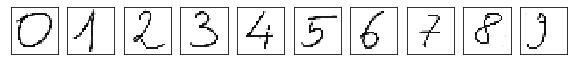

In [43]:
plt.figure(figsize=(12,4))
for i,M in enumerate(input_data):  
    plt.subplot(1,12,i+1)
    plt.imshow(input_data[i], cmap='binary', interpolation='none');
    plt.xticks([]); plt.yticks([])

Ajout de la dimension 'canal gris' et normalisation des images :

In [44]:
nb_images = input_data.shape[0]
# reshape des matrices + transformation en flots :
X_photo = input_data.reshape(nb_images, 28,28,1).astype('float32')
# normalisation des données :
X_photo /= 255

In [45]:
rep = model.predict(X_photo)
with np.printoptions(formatter={'float': '{:0.4f}'.format}): print(rep)

[[0.9998 0.0000 0.0002 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.8686 0.0000 0.0000 0.1311 0.0000 0.0000 0.0004 0.0000 0.0000]
 [0.0011 0.0002 0.9982 0.0002 0.0000 0.0000 0.0000 0.0000 0.0003 0.0000]
 [0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0000 0.0000 0.0000 0.0000 0.9998 0.0000 0.0000 0.0000 0.0000 0.0002]
 [0.0000 0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000]
 [0.0001 0.0000 0.0000 0.0000 0.0000 0.2765 0.6811 0.0000 0.0423 0.0000]
 [0.0000 0.0010 0.1706 0.2795 0.0001 0.0000 0.0000 0.5359 0.0127 0.0001]
 [0.0000 0.0002 0.0000 0.0000 0.0001 0.0267 0.0042 0.0000 0.9689 0.0000]
 [0.0000 0.3166 0.0001 0.6745 0.0000 0.0054 0.0000 0.0031 0.0002 0.0002]]


In [46]:
[r.argmax() for r in model.predict(X_photo)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 3]